In [2]:
import os
import rootplotlib as rpl
import ROOT

from copy import copy, deepcopy
from tqdm import tqdm
from copy import deepcopy     
from ROOT import kBlack,kBlue,kRed,kAzure,kGreen,kMagenta,kCyan,kOrange,kGray,kYellow,kWhite,TColor,gStyle, TH1F
from expand_folders import expand_folders
from prettytable import PrettyTable


rpl.set_atlas_style()
rpl.suppress_root_warnings()
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Module libc not found.


Welcome to JupyROOT 6.26/10

Applying ATLAS style settings...


In [3]:
basepath='/mnt/cern_data/joao.pinto/data17_13TeV/files/commissioning/quadrant_EGAM1_e28_ringer_and_noringer_2017_after_ts1'
filename='data17_13TeV.AllYear_afterTS1.EGAM1.probes_lhtight.Quadrant.root'
path=basepath+'/'+filename



In [4]:
# As found in PlotVariables
varname_to_tex = {      'et' : 'E_{T}'
                     , 'eta' : '#eta'
                     , 'phi' : '#phi'
                     , 'rhad' : 'R_{had}'
                     , 'reta' : 'R_{#eta}'
                     , 'deltaEta1' : '#Delta#eta_{1}'
                     , 'weta2': 'w_{#eta,2}'
                     , 'wtots1': 'w_{tots,1}'
                     , 'f1' : 'f_{1}'
                     , 'rphi' : 'R_{#phi}'
                     , 'f3' : 'f_{3}'
                     , 'eratio' : 'E_{ratio}'
                     , 'deltaPhiRescaled2' : '#Delta#phi_{res}'
                     , 'd0significance' : 'd_{0}/#sigma_{d_{0}}'
                     , 'trackd0pvunbiased' : 'd_{0}'
                     , 'eProbabilityHT' :  'eProbabilityHT'
                     , 'TRT_PID' : 'TRT_{PID}'
                     , 'DeltaPOverP' : '#Delta p/p'
                 }

et_bins  = [15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,50000.0] 
eta_bins = [ 0.0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37, 2.47 ]

In [5]:
def get_histograms( path ) :

    from ROOT import TFile
    from copy import deepcopy
    f = TFile(path, 'read') 
    dir_name="HLT_e28_lhtight_nod0_noringer_ivarloose_Vs_HLT_e28_lhtight_nod0_ivarloose"
    quadrant_names=[('pp','passed_passed'),('pr','passed_rejected'),('rp','rejected_passed'),('rr','rejected_rejected')]
    var_names=['et','eta','phi','avgmu','nvtx','weta2','f1','f3','deltaEta1','wtots1','d0significance','reta','rphi','eratio','rhad','trackd0pvunbiased']
    d = { var_name : [[{} for _ in range(len(eta_bins))] for __ in range(len(et_bins))] for var_name in var_names }
    
    for var_name in var_names:
        for et_bin in range(len(et_bins)):
            for eta_bin in range(len(eta_bins)):
                bin_name=f'et{et_bin}_eta{eta_bin}'
                d[var_name][et_bin][eta_bin]={}
                for alias, quadrant_name in quadrant_names:
                    hpath=f'/Event/QuadrantTool/{dir_name}/{bin_name}/{quadrant_name}/{var_name}'
                    h = f.Get(hpath)
                    d[var_name][et_bin][eta_bin][alias]=deepcopy(h)
    f.Close()
    return d

hists = get_histograms(path)


In [6]:
def get_transparence( color , value=.5 ):
    return ROOT.TColor.GetColorTransparent(color,value)

def plot_quadrant( h_pp, h_pr, h_rp, h_rr, xlabel='', ylabel='', rlabel=''):

    msize=0.8
    ref_hist = h_pp.Clone()
    ref_hist.Add(h_pr)
    ref_hist.Add(h_rp)
    ref_hist.Add(h_rr)
    
    drawopt='histE2 L same'
    fig = rpl.create_ratio_canvas("canvas", "", 500, 550)
    rpl.set_figure(fig)
    
    h_pp.SetLineColor( kBlack ) 
    h_pp.SetMarkerColor( kBlack ) 
    h_pp.SetFillColor(get_transparence(kBlack))
    h_pp.SetMarkerStyle(53)
    h_pp.SetMarkerSize(msize)
    rpl.add_hist(h_pp, drawopt, pad='pad_top')

    h_pr.SetLineColor( kRed ) 
    h_pr.SetMarkerColor( kRed ) 
    h_pr.SetFillColor(get_transparence(kRed))
    h_pr.SetMarkerStyle(54)
    h_pr.SetMarkerSize(msize)
    rpl.add_hist(h_pr, drawopt, pad='pad_top')
    div_pr = h_pr.Clone()
    div_pr.Divide(div_pr, ref_hist, 1.,1.,'b')
    [div_pr.SetBinError(b,0.0) for b in range(div_pr.GetNbinsX())]

    h_rp.SetLineColor( kBlue ) 
    h_rp.SetMarkerColor( kBlue ) 
    h_rp.SetFillColor(get_transparence(kBlue))
    h_rp.SetMarkerStyle(55)
    h_rp.SetMarkerSize(msize)
    rpl.add_hist(h_rp, drawopt, pad='pad_top')
    div_rp = h_rp.Clone()
    div_rp.Divide(div_rp, ref_hist, 1.,1.,'b')
    [div_rp.SetBinError(b,0.0) for b in range(div_rp.GetNbinsX())]

    h_rr.SetLineColor( kGray ) 
    h_rr.SetMarkerColor( kGray ) 
    h_rr.SetFillColor(get_transparence(kGray))
    h_rr.SetMarkerStyle(56)
    h_rr.SetMarkerSize(msize)
    rpl.add_hist(h_rr, drawopt, pad='pad_top')

    fig.set_xlabel(xlabel, pad="pad_bot")
    fig.set_ylabel(rlabel, pad="pad_bot")
    fig.set_ylabel(ylabel, pad="pad_top")
    rpl.set_axis_labels(xlabel,ylabel,rlabel)

    # prepare botton plot
    disagree_sum = div_rp.Clone()
    disagree_sum.Add(div_pr)
    disagree_sum.SetLineColor(kRed-7)
    disagree_sum.SetMarkerColor(kRed-7)
    disagree_sum.SetMarkerStyle(53)
    disagree_sum.GetYaxis().SetTitle(rlabel)
    rpl.add_hist( disagree_sum, 'p', pad='pad_bot')

    rpl.set_axis_labels(xlabel,ylabel,rlabel)

    rpl.format_ratio_canvas_axes(XTitleOffset=0, fig=fig)       
    return fig




def add_top_labels( et_bin, eta_bin , legends, text='Internal', et_bins=et_bins, eta_bins=eta_bins):
    rpl.add_text( 0.47, 0.90, 'ATLAS'   , textsize=0.025, textfont=72)
    rpl.add_text( 0.56, 0.90, text, textsize=0.025, textfont=42)
    rpl.add_text( 0.50, 0.85, 'data 2017', textsize=0.025)
    rpl.add_text( 0.495, 0.80, '#sqrt{s}= 13TeV', textsize=0.025)

    def bins_to_latex( etidx, etaidx, et_bins=et_bins, eta_bins=eta_bins):
        text=[]
        _etlist = copy(et_bins)
        _etalist = copy(eta_bins)
        if _etlist[-1]>9999:  _etlist[-1]='#infty'
        binEt = (str(_etlist[etidx]) + ' < E_{T} [GeV] < ' + str(_etlist[etidx+1]) if etidx+1 < len(_etlist) else
                                     'E_{T} > ' + str(_etlist[etidx]) + ' GeV')
        text.append(binEt)
        binEta = (str(_etalist[etaidx]) + ' < #eta < ' + str(_etalist[etaidx+1]) if etaidx+1 < len(_etalist) else
                                        str(_etalist[etaidx]) + ' < #eta < 2.47')
        text.append(binEta)
        return text
    textbins = bins_to_latex(et_bin,eta_bin, et_bins, eta_bins )
    rpl.add_text( 0.2, 0.90, textbins[0], textsize=0.025)
    rpl.add_text( 0.2, 0.80, textbins[1], textsize=0.025)
    def add_legend(x, y, legends):
        rpl.add_legend( legends,x,y,x+0.98,y+0.20,textsize=12, option='p', pad='pad_top' )
    add_legend( 0.7, 0.77, legends)


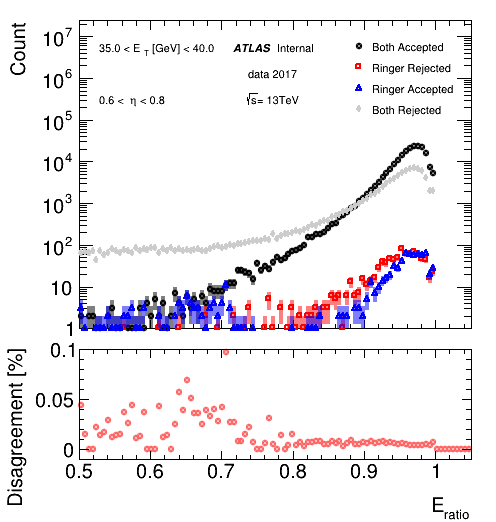

In [9]:
et_bin = 4
eta_bin = 1
fig = plot_quadrant( hists['eratio'][et_bin][eta_bin]['pp'],
                     hists['eratio'][et_bin][eta_bin]['pr'],
                     hists['eratio'][et_bin][eta_bin]['rp'],
                     hists['eratio'][et_bin][eta_bin]['rr'],
                     ylabel='Count',
                     xlabel='E_{ratio}',
                     rlabel='Disagreement [%]',
                   )
                   
add_top_labels(et_bin, eta_bin, ['Both Accepted', 'Ringer Rejected', 'Ringer Accepted', 'Both Rejected'])
pad = fig.get_pad("pad_top")
pad.SetLogy()
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1000, pad='pad_top') 

rpl.set_yaxis_ranges(-0.01, 0.1, pad='pad_bot')
fig.show()
fig.savefig('eratio.pdf')

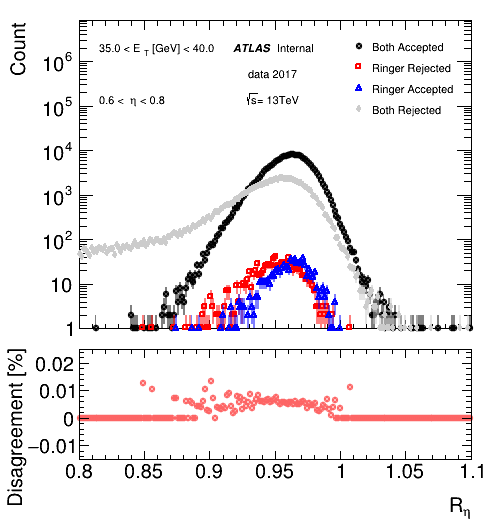

In [31]:
et_bin = 4
eta_bin = 1
fig = plot_quadrant( hists['reta'][et_bin][eta_bin]['pp'],
                     hists['reta'][et_bin][eta_bin]['pr'],
                     hists['reta'][et_bin][eta_bin]['rp'],
                     hists['reta'][et_bin][eta_bin]['rr'],
                     ylabel='Count',
                     xlabel='R_{#eta}',
                     rlabel='Disagreement [%]',
                   )
                   
add_top_labels(et_bin, eta_bin, ['Both Accepted', 'Ringer Rejected', 'Ringer Accepted', 'Both Rejected'])
pad = fig.get_pad("pad_top")
pad.SetLogy()
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1000, pad='pad_top') 
rpl.set_yaxis_ranges(-0.015, 0.025, pad='pad_bot')

fig.show()
fig.savefig('reta.pdf')

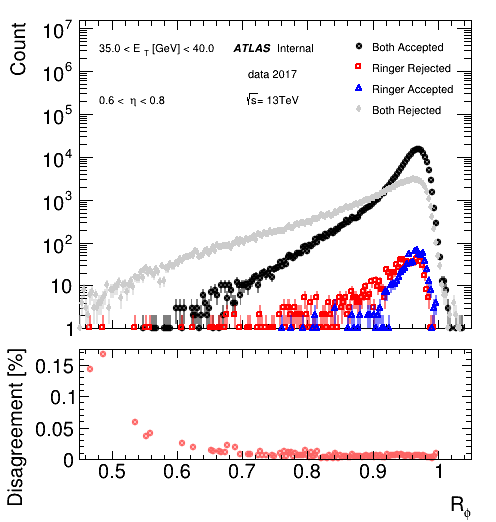

In [8]:
et_bin = 4
eta_bin = 1
fig = plot_quadrant( hists['rphi'][et_bin][eta_bin]['pp'],
                     hists['rphi'][et_bin][eta_bin]['pr'],
                     hists['rphi'][et_bin][eta_bin]['rp'],
                     hists['rphi'][et_bin][eta_bin]['rr'],
                     ylabel='Count',
                     xlabel='R_{#phi}',
                     rlabel='Disagreement [%]',
                   )
                   
add_top_labels(et_bin, eta_bin, ['Both Accepted', 'Ringer Rejected', 'Ringer Accepted', 'Both Rejected'])
pad = fig.get_pad("pad_top")
pad.SetLogy()
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1000, pad='pad_top') 
fig.show()
fig.savefig('rphi.pdf')

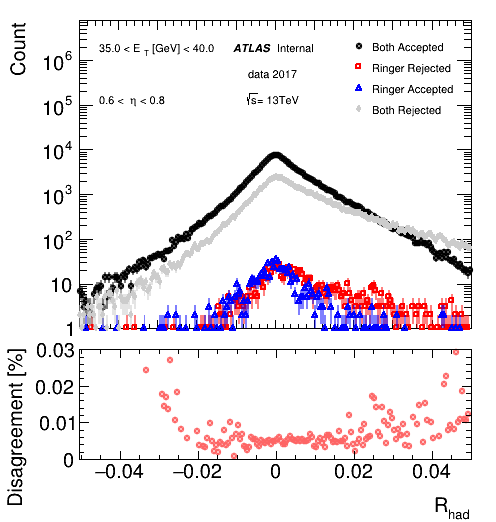

In [41]:
et_bin = 4
eta_bin = 1
fig = plot_quadrant( hists['rhad'][et_bin][eta_bin]['pp'],
                     hists['rhad'][et_bin][eta_bin]['pr'],
                     hists['rhad'][et_bin][eta_bin]['rp'],
                     hists['rhad'][et_bin][eta_bin]['rr'],
                     ylabel='Count',
                     xlabel='R_{had}',
                     rlabel='Disagreement [%]',
                   )
                   
add_top_labels(et_bin, eta_bin, ['Both Accepted', 'Ringer Rejected', 'Ringer Accepted', 'Both Rejected'])
pad = fig.get_pad("pad_top")
pad.SetLogy()
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1000, pad='pad_top') 
rpl.set_yaxis_ranges(-0.0, 0.03, pad='pad_bot')
rpl.fix_xaxis_ranges(xminf=1.1, xminc=0., pad='pad_bot') 

fig.show()
fig.savefig('rhad.pdf')

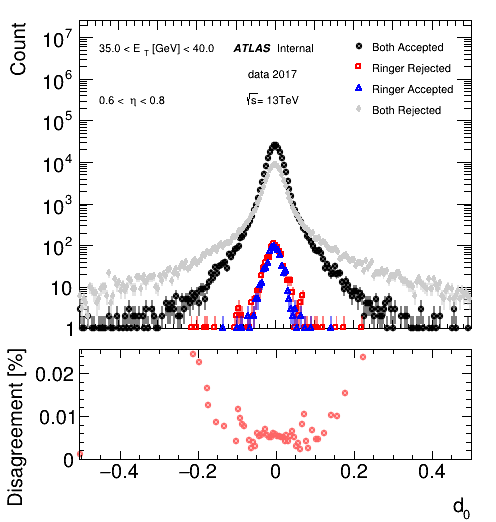

In [42]:
et_bin = 4
eta_bin = 1
fig = plot_quadrant( hists['trackd0pvunbiased'][et_bin][eta_bin]['pp'],
                     hists['trackd0pvunbiased'][et_bin][eta_bin]['pr'],
                     hists['trackd0pvunbiased'][et_bin][eta_bin]['rp'],
                     hists['trackd0pvunbiased'][et_bin][eta_bin]['rr'],
                     ylabel='Count',
                     xlabel='d_{0}',
                     rlabel='Disagreement [%]',
                   )
                   
add_top_labels(et_bin, eta_bin, ['Both Accepted', 'Ringer Rejected', 'Ringer Accepted', 'Both Rejected'])
pad = fig.get_pad("pad_top")
pad.SetLogy()
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1000, pad='pad_top') 
rpl.fix_xaxis_ranges(xminf=1.1, xminc=0., pad='pad_bot') 

fig.show()
fig.savefig('d0.pdf')